<a href="https://colab.research.google.com/github/Raghad-Odwan/DermAI-Train/blob/main/DermAI_Model_Training_Final%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



# Student model training session


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p /content/drive/MyDrive/checkpoints

In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
%%javascript
function ClickConnect(){
    console.log("Preventing Colab timeout");
    document.querySelector("colab-toolbar-button#connect").click();
}
setInterval(ClickConnect, 60000)

<IPython.core.display.Javascript object>



---



# **DermAI_AI_Model_Training**

This Google Colab notebook has been prepared for the preparation and training of a machine learning model specialized in skin cancer detection.
The model performs binary classification of skin lesion images into two categories: Benign and Malignant.


### Dataset Source

The dataset used in this project was collected from the following sources:
(                  _____                )

The dataset contains approximately 13,249 benign and 6,211 malignant images, providing a total of around 19,460 samples used for training, validation, and testing.




---




### Notebook Structure

This notebook is organized into three main sections:

**-Data Loading, Verification, and Preprocessing**

This section focuses on importing the dataset, verifying its structure, cleaning inconsistencies, and performing Exploratory Data Analysis (EDA).
Steps include resizing, normalization, data augmentation, and splitting the dataset into training, validation, and testing subsets.

**-Model Training and Evaluation**

In this section, a machine learning model is implemented and trained for skin lesion classification.
The process includes model configuration, training, and performance evaluation using metrics such as accuracy, precision, recall, and F1-score.
Optimization methods are also applied to ensure stable and efficient training.

**-Result Interpretation and Visualization**

This part is dedicated to analyzing the model’s predictions and interpreting its decision-making process using Grad-CAM and other visualization tools.
It highlights how the model distinguishes between benign and malignant lesions, providing insights into reliability and interpretability.



---


**Note: This notebook represents a core component of the DermAI Graduation Project at Palestine Technical University – Kadoorie.
It aims to demonstrate the end-to-end process of building an intelligent, interpretable, and efficient system for skin cancer classification, contributing to early detection and supporting clinical decision-making.**


---



## 1. **Part One: Dataset Preparation & Preprocessing**

In [6]:
# Import required libraries
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from collections import defaultdict
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Define main dataset path
base_dir = "/content/drive/MyDrive/Dataset/Dataset"
folders = ["benign", "malignant"]

print("Base directory:", base_dir)
for folder in folders:
    path = os.path.join(base_dir, folder)
    print(f"{folder}: {len(os.listdir(path))} files")

Base directory: /content/drive/MyDrive/Dataset/Dataset
benign: 13294 files
malignant: 6211 files


In [8]:
# Create a folder for problematic images
dup_dir = os.path.join(base_dir, "duplicates_or_corrupted")
os.makedirs(dup_dir, exist_ok=True)
print("Duplicate/Corrupted folder created at:", dup_dir)

Duplicate/Corrupted folder created at: /content/drive/MyDrive/Dataset/Dataset/duplicates_or_corrupted


In [9]:
# Define an image cleaning class
class ImageCleaner:
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.folders_to_check = ['benign', 'malignant']
        self.problem_folder = self.base_path / 'duplicates_or_corrupted'
        self.problem_folder.mkdir(exist_ok=True)
        self.stats = {'total_checked': 0, 'corrupted': 0, 'duplicates': 0, 'low_quality': 0, 'healthy': 0}
        self.image_hashes = defaultdict(list)

    def calculate_hash(self, image_path):
        import hashlib
        try:
            hasher = hashlib.md5()
            with open(image_path, 'rb') as f:
                buf = f.read()
                hasher.update(buf)
            return hasher.hexdigest()
        except:
            return None

    def is_image_corrupted(self, image_path):
        try:
            with Image.open(image_path) as img:
                img.verify()
            return False
        except:
            return True

    def check_image_quality(self, image_path, min_width=50, min_height=50):
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                if width < min_width or height < min_height:
                    return False
                if os.path.getsize(image_path) < 1000:
                    return False
            return True
        except:
            return False

    def move_to_problem_folder(self, image_path):
        try:
            dest_subfolder = self.problem_folder / image_path.parent.name
            dest_subfolder.mkdir(exist_ok=True)
            shutil.move(str(image_path), str(dest_subfolder / image_path.name))
        except Exception as e:
            print(f"Error moving {image_path.name}: {e}")

    def clean_folder(self, folder_name):
        folder_path = self.base_path / folder_name
        image_exts = ['.jpg', '.jpeg', '.png']
        images = [f for f in folder_path.iterdir() if f.suffix.lower() in image_exts]
        print(f"Cleaning {folder_name} ({len(images)} images)...")

        for img_path in tqdm(images, desc=f"Checking {folder_name}"):
            self.stats['total_checked'] += 1
            if self.is_image_corrupted(img_path):
                self.move_to_problem_folder(img_path)
                self.stats['corrupted'] += 1
                continue
            if not self.check_image_quality(img_path):
                self.move_to_problem_folder(img_path)
                self.stats['low_quality'] += 1
                continue
            img_hash = self.calculate_hash(img_path)
            if img_hash in self.image_hashes:
                self.move_to_problem_folder(img_path)
                self.stats['duplicates'] += 1
            else:
                self.image_hashes[img_hash].append(str(img_path))
                self.stats['healthy'] += 1

    def clean_all(self):
        for folder in self.folders_to_check:
            self.clean_folder(folder)
        print("\nCleaning Summary:")
        for k, v in self.stats.items():
            print(f"{k}: {v}")

# Run the cleaning process
cleaner = ImageCleaner(base_dir)
cleaner.clean_all()

Cleaning benign (13294 images)...


Checking benign: 100%|██████████| 13294/13294 [05:59<00:00, 36.95it/s] 


Cleaning malignant (6211 images)...


Checking malignant: 100%|██████████| 6211/6211 [02:59<00:00, 34.63it/s] 


Cleaning Summary:
total_checked: 19505
corrupted: 0
duplicates: 0
low_quality: 0
healthy: 19505


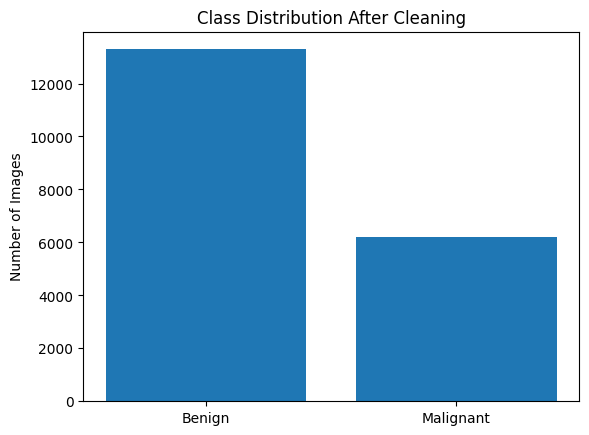

In [10]:
# Visualize class distribution
count_benign = len(os.listdir(os.path.join(base_dir, "benign")))
count_malignant = len(os.listdir(os.path.join(base_dir, "malignant")))
plt.bar(["Benign", "Malignant"], [count_benign, count_malignant])
plt.title("Class Distribution After Cleaning")
plt.ylabel("Number of Images")
plt.show()

In [11]:
# Resize all images to (224x224)
IMG_SIZE = (224, 224)
for cat in folders:
    src_dir = os.path.join(base_dir, cat)
    files = os.listdir(src_dir)
    for fname in tqdm(files, desc=f"Resizing {cat}"):
        path = os.path.join(src_dir, fname)
        try:
            img = cv2.imread(path)
            if img is None: continue
            resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
            cv2.imwrite(path, resized)
        except:
            continue

Resizing malignant: 100%|██████████| 6211/6211 [02:03<00:00, 50.35it/s]


In [12]:
# Split dataset (70% train, 15% val, 15% test)
split_dir = "/content/ai/Dataset_split"
os.makedirs(split_dir, exist_ok=True)

rows = []
for label in folders:
    path = os.path.join(base_dir, label)
    for fname in os.listdir(path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            rows.append({'path': os.path.join(path, fname), 'label': label})

df = pd.DataFrame(rows)
train_temp, test = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train, val = train_test_split(train_temp, test_size=0.1765, stratify=train_temp['label'], random_state=42)

for subset in ['train', 'val', 'test']:
    for label in folders:
        os.makedirs(os.path.join(split_dir, subset, label), exist_ok=True)

def copy_images(df_subset, subset_name):
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc=f"Copying {subset_name}"):
        dest = os.path.join(split_dir, subset_name, row['label'], os.path.basename(row['path']))
        shutil.copy2(row['path'], dest)

copy_images(train, "train")
copy_images(val, "val")
copy_images(test, "test")

print(f"\nDataset split completed successfully!")
print(f"Train: {len(train)} | Val: {len(val)} | Test: {len(test)}")

Copying test: 100%|██████████| 2926/2926 [00:11<00:00, 253.76it/s]


Dataset split completed successfully!
Train: 13652 | Val: 2927 | Test: 2926




---

####  Build DataFrame & Quick Integrity Check

In [13]:
# Count the number of image files in each class folder (benign and malignant)
# This function walks through all subdirectories and counts only valid image files.
import os, sys, traceback
base_path = "/content/drive/MyDrive/Dataset/Dataset"

def count_images_in_folder(folder):
    exts = ('.jpg','.jpeg','.png','.bmp')
    cnt = 0
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(exts):
                cnt += 1
    return cnt

for cls in ['benign','malignant']:
    p = os.path.join(base_path, cls)
    if not os.path.exists(p):
        print(f" WARNING: folder not found: {p}")
    else:
        print(f"{cls}: {count_images_in_folder(p):,} images")

benign: 13,294 images
malignant: 6,211 images


In [14]:
import os
import pandas as pd
from PIL import Image
import random
# build dataframe (paths + labels)
rows=[]
exts = ('.jpg','.jpeg','.png','.bmp')
for cls in ['benign','malignant']:
    folder = os.path.join(base_path, cls)
    if not os.path.exists(folder):
        continue
    for root, dirs, files in os.walk(folder):
        for fname in files:
            if fname.lower().endswith(exts):
                rows.append({'path': os.path.join(root, fname), 'label': cls})

df = pd.DataFrame(rows)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['label_idx'] = df['label'].map({'benign':0, 'malignant':1})
print("Total samples:", len(df))
print(df['label'].value_counts())

Total samples: 19505
label
benign       13294
malignant     6211
Name: count, dtype: int64


In [15]:
#  quick corrupted-files check (lightweight, may take time if dataset big)
#  try to open the first N images from each class to detect obvious corruption
from PIL import Image
import random

def check_samples(df, n_per_class=20):
    corrupted = []
    for cls in df['label'].unique():
        paths = df[df['label']==cls]['path'].tolist()
        sample_paths = random.sample(paths, min(n_per_class, len(paths)))
        for p in sample_paths:
            try:
                img = Image.open(p)
                img.verify()
            except Exception as e:
                corrupted.append((p, str(e)))
    return corrupted

corrupted_examples = check_samples(df, n_per_class=30)
if corrupted_examples:
    print(" Found corrupted or unreadable sample(s):", len(corrupted_examples))
    for p,err in corrupted_examples[:5]:
        print("-", p, "=>", err)
else:
    print(" Quick corrupted-sample check passed successfully (no issues in sampled files).")

 Quick corrupted-sample check passed successfully (no issues in sampled files).


In [16]:
# Save metadata CSV
out_csv = "/content/drive/MyDrive/ai/data/df_metadata.csv"
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df.to_csv(out_csv, index=False)
print(" Metadata saved to:", out_csv)

 Metadata saved to: /content/drive/MyDrive/ai/data/df_metadata.csv


In [17]:
display(df.head(10))
print("\nCounts (sanity):")
print(df['label'].value_counts())

,path,label,label_idx
0,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
1,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
2,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
3,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
4,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
5,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
6,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
7,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
8,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
9,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1



Counts (sanity):
label
benign       13294
malignant     6211
Name: count, dtype: int64


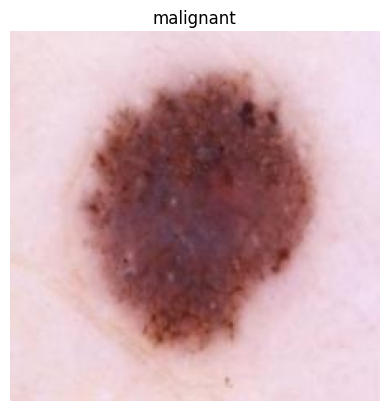

In [19]:
# Quick test reading data
# Randomly load and display one sample image from the dataset
# to verify that image paths are correct and preprocessing worked properly.
from tensorflow.keras.preprocessing import image
import numpy as np
import random
import matplotlib.pyplot as plt

sample = random.choice(df['path'].tolist())
img = image.load_img(sample, target_size=(224,224))
plt.imshow(img)
plt.axis('off')
plt.title(sample.split('/')[-2])
plt.show()



---



## **Part Two: Model Training and Evaluation**

In [20]:
# Import libraries
import os, math, gc
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger

# Parameters
# Defines image size, batch size, epochs, and model saving directory
DRIVE_BASE = "/content/drive/MyDrive"
DF_PATH = os.path.join(DRIVE_BASE, "ai/data/df_metadata.csv")
MODELS_DIR = os.path.join(DRIVE_BASE, "DermAI_models_resnet")
os.makedirs(MODELS_DIR, exist_ok=True)

IMG_SIZE = (224,224)
BATCH_SIZE = 16
EPOCHS = 15
N_FOLDS = 3
RANDOM_STATE = 42
VERBOSE = 1

In [21]:
# Set random seeds for reproducibility
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [22]:
# Read & Inspect Metadata
meta_csv = "/content/drive/MyDrive/ai/data/df_metadata.csv"
df = pd.read_csv(meta_csv)

print("Loaded df:", meta_csv)
print("Total samples:", len(df))
print("\nLabel distribution:")
print(df['label'].value_counts())
print("\nFirst 10 rows:")
display(df.head(10))

# Prepare X and y for training
X = df['path'].values
y = df['label_idx'].values

Loaded df: /content/drive/MyDrive/ai/data/df_metadata.csv
Total samples: 19505

Label distribution:
label
benign       13294
malignant     6211
Name: count, dtype: int64

First 10 rows:


,path,label,label_idx
0,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
1,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
2,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
3,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
4,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
5,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
6,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
7,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
8,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
9,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1


Data Generators

In [23]:
# Prepare image generators for training and validation.
# Training generator applies data augmentation to improve model generalization,
# while validation generator only rescales pixel values.

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)



---



In [24]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled.")

Mixed precision enabled.




---



Model Building

In [49]:
# Build ResNet with a single-sigmoid output (binary)
# Build binary ResNet50 with fine-tuning
def build_resnet_binary(input_shape=(224,224,3)):
    base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base.layers[:-20]:
    layer.trainable = False
for layer in base.layers[-20:]:
    layer.trainable = True

    # Unfreeze last 40 layers for fine-tuning
    for layer in base.layers[:-40]:
        layer.trainable = False
    for layer in base.layers[-40:]:
        layer.trainable = True

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base.input, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),  # smaller LR for fine-tuning
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

NameError: name 'base' is not defined



---



In [26]:
# create a copy of data locally
import os, shutil, time
DRIVE_SPLIT = "/content/ai/Dataset_split"
LOCAL_SPLIT = "/content/local_dataset_split"

if not os.path.exists(LOCAL_SPLIT):
    print("Copying dataset to local disk (may take several minutes)...")
    start=time.time()
    shutil.copytree(DRIVE_SPLIT, LOCAL_SPLIT)
    print("Copy finished in %.1f s" % (time.time()-start))
else:
    print("Local dataset already exists:", LOCAL_SPLIT)

Copying dataset to local disk (may take several minutes)...
Copy finished in 2.0 s


In [27]:
# Build local dataframe from the copied split
import pandas as pd, os
rows = []
for subset in ['train','val','test']:
    for cls in ['benign','malignant']:
        p = os.path.join(LOCAL_SPLIT, subset, cls)
        if not os.path.exists(p): continue
        for f in os.listdir(p):
            if f.lower().endswith(('.jpg','.jpeg','.png')):
                rows.append({
                    'path': os.path.join(p,f),
                    'label': cls,
                    'label_idx': 0 if cls=='benign' else 1,
                    'subset': subset
                })
df_local = pd.DataFrame(rows).sample(frac=1, random_state=42).reset_index(drop=True)
print("Local dataset summary:\n", df_local.groupby(['subset','label']).size())

Local dataset summary:
 subset  label    
test    benign       1994
        malignant     932
train   benign       9305
        malignant    4347
val     benign       1995
        malignant     932
dtype: int64


In [28]:
%%bash
nohup bash -c 'while true; do date; nvidia-smi; echo "--------------------------------------------------"; sleep 300; done' > /content/gpu_monitor.log 2>&1 &
echo "GPU monitor started — logging to /content/gpu_monitor.log"

GPU monitor started — logging to /content/gpu_monitor.log




---



In [29]:
# Utility Functions for Dataset Loading & Preprocessing
AUTOTUNE = tf.data.AUTOTUNE

def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

def make_dataset(paths, labels, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(2048)
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

In [30]:
# Start Fold Preparation and Speed Test
from sklearn.model_selection import StratifiedKFold
import numpy as np, time, math

# Prepare CV on train, val
df_cv = df_local[df_local['subset'] != 'test'].reset_index(drop=True)
X = df_cv['path'].values
y = df_cv['label_idx'].values

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
train_idx, val_idx = next(skf.split(X, y))  # خذ fold1 فقط
train_paths, train_labels = X[train_idx], y[train_idx]
val_paths, val_labels = X[val_idx], y[val_idx]


train_ds = make_dataset(train_paths, train_labels, shuffle=True)
val_ds = make_dataset(val_paths, val_labels, shuffle=False)

# build small frozen ResNet for test speed
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def build_resnet_small():
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0],IMG_SIZE[1],3))
    base.trainable = False
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(2, activation='softmax', dtype='float32')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_resnet_small()

# measure speed (K batches)
K = 50
it = iter(train_ds)
# warm up
_ = next(it)
start = time.time()
for i in range(K):
    try:
        xb, yb = next(it)
    except StopIteration:
        it = iter(train_ds); xb, yb = next(it)
    model.train_on_batch(xb, yb)
elapsed = time.time() - start
sec_per_step = elapsed / K
steps_per_epoch = math.ceil(len(train_paths)/BATCH_SIZE)
print("sec_per_step:", sec_per_step)
print("Estimated epoch time (min):", (steps_per_epoch*sec_per_step)/60)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
sec_per_step: 0.37627678871154785
Estimated epoch time (min): 4.333454349994659




---





---



In [31]:
# DIAGNOSTIC: check label distribution and generator mapping
import numpy as np, math, os

print("df_local summary (first 10 rows):")
display(df_local.head(10))
print("\nGlobal df label counts:\n", df['label'].value_counts())
print("\nLocal df counts by subset & label:\n", df_local.groupby(['subset','label']).size())

# If train_gen/val_gen exist, inspect them
if 'train_gen' in globals():
    print("\ntrain_gen.class_indices:", getattr(train_gen, 'class_indices', None))
    if hasattr(train_gen, 'classes'):
        u, c = np.unique(train_gen.classes, return_counts=True)
        print("train_gen.classes counts:", dict(zip(u,c)))
if 'val_gen' in globals():
    print("\nval_gen.class_indices:", getattr(val_gen, 'class_indices', None))
    if hasattr(val_gen, 'classes'):
        u, c = np.unique(val_gen.classes, return_counts=True)
        print("val_gen.classes counts:", dict(zip(u,c)))

# Quick direct check using val_paths/val_labels if available
if 'val_paths' in globals() and 'val_labels' in globals():
    import collections
    print("\nval_labels distribution (array):", dict(collections.Counter(val_labels)))
else:
    print("\nval_paths/val_labels not found — skip array check.")

# Sample model prediction test (works if `model` exists in memory)
if 'model' in globals() and ('val_gen' in globals() or ('val_paths' in globals() and 'val_labels' in globals())):
    print("\nRunning sample prediction check (first batch)...")
    try:
        if 'val_gen' in globals():
            val_gen.batch_size = min(16, val_gen.batch_size)
            val_gen.reset()
            xb, yb = next(val_gen)
            probs = model.predict(xb, verbose=0)
            if probs.ndim == 2 and probs.shape[1] == 2:
                preds = np.argmax(probs, axis=1)
            else:
                preds = (probs.ravel() > 0.5).astype(int)
            print("sample true unique:", np.unique(yb, return_counts=True))
            print("sample preds unique:", np.unique(preds, return_counts=True))
            print("sample probs (first 6):", probs[:6])
        else:
            # load 16 imgs from val_paths
            import tensorflow as tf
            def load_img(p):
                img = tf.io.read_file(p)
                img = tf.image.decode_jpeg(img, channels=3)
                img = tf.image.resize(img, (224,224))
                return (img/255.0).numpy()
            xb = np.stack([load_img(p) for p in val_paths[:16]])
            probs = model.predict(xb)
            print("sample probs (first 6):", probs[:6])
    except Exception as e:
        print("Prediction test failed:", e)
else:
    print("\nModel or validation data not available in memory for sample prediction.")


df_local summary (first 10 rows):


,path,label,label_idx,subset
0,/content/local_dataset_split/train/benign/ISIC...,benign,0,train
1,/content/local_dataset_split/train/benign/mela...,benign,0,train
2,/content/local_dataset_split/train/benign/mela...,benign,0,train
3,/content/local_dataset_split/train/benign/mela...,benign,0,train
4,/content/local_dataset_split/train/benign/mela...,benign,0,train
5,/content/local_dataset_split/train/malignant/m...,malignant,1,train
6,/content/local_dataset_split/val/benign/ISIC_0...,benign,0,val
7,/content/local_dataset_split/train/malignant/m...,malignant,1,train
8,/content/local_dataset_split/train/benign/mela...,benign,0,train
9,/content/local_dataset_split/test/benign/ISIC_...,benign,0,test



Global df label counts:
 label
benign       13294
malignant     6211
Name: count, dtype: int64

Local df counts by subset & label:
 subset  label    
test    benign       1994
        malignant     932
train   benign       9305
        malignant    4347
val     benign       1995
        malignant     932
dtype: int64

val_labels distribution (array): {np.int64(0): 3767, np.int64(1): 1760}

Running sample prediction check (first batch)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
sample probs (first 6): [[0.82809556 0.17190447]
 [0.8334427  0.16655731]
 [0.8305646  0.16943532]
 [0.82961994 0.17038013]
 [0.83063674 0.16936323]
 [0.83027947 0.16972055]]


In [39]:
# REBUILD generators explicitly using label_idx and binary mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Keep the same augmentations you already used
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.8,1.2),
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Recreate pandas train_df and val_df for the current fold (example uses train_df/val_df variables used in the CV loop)
# If you don't have these, please create them from X/ y like in your CV loop:
# train_df = pd.DataFrame({'path': X[train_idx], 'label_idx': y[train_idx]})
# val_df   = pd.DataFrame({'path': X[val_idx],   'label_idx': y[val_idx]})

# Example rebuild (if train_df and val_df exist)
train_gen = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='label_idx',
                                              target_size=IMG_SIZE, class_mode='raw', # raw -> returns 0/1 values
                                              batch_size=BATCH_SIZE, shuffle=True)
val_gen = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label_idx',
                                          target_size=IMG_SIZE, class_mode='raw',
                                          batch_size=BATCH_SIZE, shuffle=False)

print("Rebuilt generators. train_gen.class_indices:", getattr(train_gen, 'class_indices', None))
if hasattr(train_gen, 'classes'):
    import numpy as np
    u,c = np.unique(train_gen.classes, return_counts=True)
    print("train counts:", dict(zip(u,c)))
    u,c = np.unique(val_gen.classes, return_counts=True)
    print("val counts:", dict(zip(u,c)))


Found 11052 validated image filenames.
Found 5527 validated image filenames.
Rebuilt generators. train_gen.class_indices: None


In [40]:
# QUICK SMOKE RUN using the rebuilt generators & binary model
model = build_resnet_binary(input_shape=(IMG_SIZE[0],IMG_SIZE[1],3))
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
]

steps_per_epoch = min(200, math.ceil(len(train_df) / BATCH_SIZE))  # small for test
val_steps = min(80, math.ceil(len(val_df) / BATCH_SIZE))

history = model.fit(
    train_gen,
    epochs=1,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

# Sample predictions after smoke-run
val_gen.reset()
probs = model.predict(val_gen, steps=val_steps, verbose=1)
preds = (probs.ravel() > 0.5).astype(int)
# get true labels from val_df for the predicted range
true = val_df['label_idx'].values[:len(preds)]
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true, preds, target_names=['benign','malignant'], zero_division=0))
print("Confusion matrix:\n", confusion_matrix(true, preds))


200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 281ms/step - accuracy: 0.7155 - loss: 0.5561 - val_accuracy: 0.7352 - val_loss: 0.6159
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
              precision    recall  f1-score   support

      benign       0.73      0.99      0.84       883
   malignant       0.88      0.17      0.28       397

    accuracy                           0.74      1280
   macro avg       0.80      0.58      0.56      1280
weighted avg       0.77      0.74      0.67      1280

Confusion matrix:
 [[874   9]
 [330  67]]


In [41]:
# Compute class weights dynamically
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y[train_idx]),
    y=y[train_idx]
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.7335722819593787), 1: np.float64(1.5703324808184143)}




---





---



In [42]:
# # For each fold:
#   • Split data into training and validation subsets while preserving class balance.
#   • Build and train a ResNet50 model on the training subset.
#   • Evaluate model performance on the validation subset (Accuracy, Precision, Recall, F1).
#   • Save best model weights and record per-fold metrics.
# Results from all folds are stored in 'fold_metrics' for later summary and analysis.
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold_metrics = []
fold_no = 1

for train_idx, val_idx in skf.split(X, y):
    print("\n" + "="*60)
    print(f" Starting Fold {fold_no}/3 — Train:{len(train_idx)} | Val:{len(val_idx)}")
    print("="*60)

    train_df = pd.DataFrame({'path': X[train_idx], 'label_idx': y[train_idx]})
    val_df   = pd.DataFrame({'path': X[val_idx],   'label_idx': y[val_idx]})

    classes = np.unique(train_df['label_idx'])
    cw = compute_class_weight('balanced', classes=classes, y=train_df['label_idx'])
    class_weight = {int(c): w for c,w in zip(classes, cw)}

    train_gen = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='label_idx',
                                                  target_size=IMG_SIZE, class_mode='raw',
                                                  batch_size=BATCH_SIZE, shuffle=True)
    val_gen = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label_idx',
                                              target_size=IMG_SIZE, class_mode='raw',
                                              batch_size=BATCH_SIZE, shuffle=False)

   # Build model with binary sigmoid head (single output)
   # Use the safe binary model definition to avoid mismatch between labels and outputs.
    model = build_resnet_binary(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    ckpt_path = os.path.join(MODELS_DIR, f"best_resnet_fold{fold_no}.keras")

    csv_log_path = os.path.join(MODELS_DIR, f"training_log_fold{fold_no}.csv")

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
        CSVLogger(csv_log_path, append=True)
    ]

    steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
    val_steps = math.ceil(len(val_df) / BATCH_SIZE)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=VERBOSE
    )


    # Evaluate model performance for this fold
    val_gen.reset()
    # For sigmoid binary output, convert probabilities to class labels with threshold 0.5
    preds_prob = model.predict(val_gen, steps=val_steps, verbose=VERBOSE)
    # preds_prob shape is (N,1) or (N,) — convert to flat array and threshold
    preds = (preds_prob.ravel() > 0.5).astype(int)

    true = val_df['label_idx'].values[:len(preds)]

    acc = accuracy_score(true, preds)
    prec = precision_score(true, preds, zero_division=0)
    rec = recall_score(true, preds, zero_division=0)
    f1 = f1_score(true, preds, zero_division=0)

    print(f"Fold {fold_no} -> acc:{acc:.4f}, prec:{prec:.4f}, rec:{rec:.4f}, f1:{f1:.4f}")
    print(classification_report(true, preds, target_names=['benign','malignant']))
    print("Confusion matrix:\n", confusion_matrix(true, preds))

    fold_metrics.append({'fold':fold_no, 'accuracy':acc,'precision':prec,'recall':rec,'f1':f1})
    fold_no += 1

    tf.keras.backend.clear_session()
    gc.collect()


 Starting Fold 1/3 — Train:11052 | Val:5527
Found 11052 validated image filenames.
Found 5527 validated image filenames.
Epoch 1/15
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.7012 - loss: 0.5618
Epoch 1: val_loss improved from inf to 0.85337, saving model to /content/drive/MyDrive/DermAI_models_resnet/best_resnet_fold1.keras
691/691 ━━━━━━━━━━━━━━━━━━━━ 226s 287ms/step - accuracy: 0.7013 - loss: 0.5617 - val_accuracy: 0.5341 - val_loss: 0.8534 - learning_rate: 1.0000e-05
Epoch 2/15
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7719 - loss: 0.4690

KeyboardInterrupt: 

In [ ]:
# Save the resultes
metrics_df = pd.DataFrame(fold_metrics)
metrics_csv = os.path.join(MODELS_DIR, "resnet3fold_metrics.csv")
metrics_df.to_csv(metrics_csv, index=False)
print("\nSaved metrics to:", metrics_csv)
print("\nPer-fold metrics:\n", metrics_df)
print("\nMean metrics:\n", metrics_df[['accuracy','precision','recall','f1']].mean())
print("\nStd metrics:\n", metrics_df[['accuracy','precision','recall','f1']].std())



---



---





---





---



In [50]:
import os, math, gc
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# Parameters
DRIVE_BASE = "/content/drive/MyDrive"
DF_PATH = os.path.join(DRIVE_BASE, "ai/data/df_metadata.csv")
MODELS_DIR = os.path.join(DRIVE_BASE, "DermAI_models_resnet")
os.makedirs(MODELS_DIR, exist_ok=True)

IMG_SIZE = (224,224)
BATCH_SIZE = 16
EPOCHS = 20
N_FOLDS = 3
RANDOM_STATE = 42
VERBOSE = 1

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.8,1.2),
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load data
df_cv = df_local[df_local['subset'] != 'test'].reset_index(drop=True)
X = df_cv['path'].values
y = df_cv['label_idx'].values

# Model definition - SOFTMAX VERSION (2 classes)
def build_resnet_softmax(input_shape=(224,224,3), n_classes=2):
    base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base.layers[:-30]:
        layer.trainable = False
    for layer in base.layers[-30:]:
        layer.trainable = True




    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(n_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs=base.input, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 3-Fold Cross Validation
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
fold_metrics = []
fold_no = 1

for train_idx, val_idx in skf.split(X, y):
    print("\n" + "="*60)
    print(f" Starting Fold {fold_no}/{N_FOLDS} - Train:{len(train_idx)} | Val:{len(val_idx)}")
    print("="*60)

    train_df = pd.DataFrame({'path': X[train_idx], 'label_idx': y[train_idx]})
    val_df = pd.DataFrame({'path': X[val_idx], 'label_idx': y[val_idx]})

    classes = np.unique(train_df['label_idx'])
    cw = compute_class_weight('balanced', classes=classes, y=train_df['label_idx'])
    malignant_boost = 2.0
    class_weight = {
        0: float(cw[0]),
        1: float(cw[1]) * malignant_boost
    }
    print(f"Class weights (boosted): {class_weight}")

    train_gen = train_datagen.flow_from_dataframe(
        train_df, x_col='path', y_col='label_idx',
        target_size=IMG_SIZE, class_mode='raw',
        batch_size=BATCH_SIZE, shuffle=True
    )
    val_gen = val_datagen.flow_from_dataframe(
        val_df, x_col='path', y_col='label_idx',
        target_size=IMG_SIZE, class_mode='raw',
        batch_size=BATCH_SIZE, shuffle=False
    )

    model = build_resnet_softmax(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), n_classes=2)
    ckpt_path = os.path.join(MODELS_DIR, f"best_resnet_fold{fold_no}.keras")
    csv_log_path = os.path.join(MODELS_DIR, f"training_log_fold{fold_no}.csv")

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        CSVLogger(csv_log_path, append=True)
    ]

    steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
    val_steps = math.ceil(len(val_df) / BATCH_SIZE)

    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=VERBOSE
    )

    val_gen.reset()
    preds_prob = model.predict(val_gen, steps=val_steps, verbose=0)
    preds = np.argmax(preds_prob, axis=1)
    true = val_df['label_idx'].values[:len(preds)]

    acc = accuracy_score(true, preds)
    prec = precision_score(true, preds, average='weighted', zero_division=0)
    rec = recall_score(true, preds, average='weighted', zero_division=0)
    f1 = f1_score(true, preds, average='weighted', zero_division=0)

    print(f"\nFold {fold_no} Results:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print("\n" + classification_report(true, preds, target_names=['benign','malignant'], zero_division=0))
    print("Confusion matrix:")
    print(confusion_matrix(true, preds))

    fold_metrics.append({
        'fold': fold_no,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })

    fold_no += 1
    tf.keras.backend.clear_session()
    gc.collect()

metrics_df = pd.DataFrame(fold_metrics)
metrics_csv = os.path.join(MODELS_DIR, "resnet3fold_metrics_corrected.csv")
metrics_df.to_csv(metrics_csv, index=False)

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print("\nPer-fold metrics:")
print(metrics_df)
print("\nMean ± Std:")
for col in ['accuracy','precision','recall','f1']:
    mean_val = metrics_df[col].mean()
    std_val = metrics_df[col].std()
    print(f"  {col}: {mean_val:.4f} ± {std_val:.4f}")
print("\nMetrics saved to:", metrics_csv)


 Starting Fold 1/3 - Train:11052 | Val:5527
Class weights (boosted): {0: 0.7335722819593787, 1: 3.1406649616368285}
Found 11052 validated image filenames.
Found 5527 validated image filenames.
Epoch 1/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5879 - loss: 0.8712
Epoch 1: val_loss improved from inf to 1.11872, saving model to /content/drive/MyDrive/DermAI_models_resnet/best_resnet_fold1.keras
691/691 ━━━━━━━━━━━━━━━━━━━━ 225s 287ms/step - accuracy: 0.5879 - loss: 0.8710 - val_accuracy: 0.4192 - val_loss: 1.1187 - learning_rate: 1.0000e-04
Epoch 2/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6729 - loss: 0.7080
Epoch 2: val_loss did not improve from 1.11872
691/691 ━━━━━━━━━━━━━━━━━━━━ 184s 267ms/step - accuracy: 0.6729 - loss: 0.7080 - val_accuracy: 0.7098 - val_loss: 1.8114 - learning_rate: 1.0000e-04
Epoch 3/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.6865 - loss: 0.6777
Epoch 3: val_loss did not improve from 1.11872
691/691 ━━━━━━━━━━

KeyboardInterrupt: 